# Traceroute Analysis

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import pycountry
from countryinfo import CountryInfo
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geocoder as gc
import geoip2.database
import geopandas
import time
import datetime
import ipinfo
from geopy import distance
import duckdb

access_token = "49efa1a852217e"
handler = ipinfo.getHandler(access_token)

parquet_dir = '../parquet'

def country_name(country_iso):
    return pycountry.countries.get(alpha_2=country_iso).name

def filter_for(df, name, value):
    return df.loc[df[name] == value]

def filter_for_unequal(df, name, value):
    return df.loc[df[name] != value]

def filter_for_range(df, name, lower_bound, upper_bound):
    return df[(df[name] >= lower_bound) & (df[name] < upper_bound)]

def days_in_month(year, month):
    return monthrange(year, month)[1]

def first_weekday_of_month(year, month):
    return monthrange(year, month)[0]

def date_to_weekday(day, month, year):
    date = datetime(year, month, day)
    return day_name[date.weekday()]

## Traceroute Success Rate per Measurement ID

In [2]:
parquet_file = f'{parquet_dir}/traceroute_data.parquet'

all = duckdb.sql(f'''
    SELECT DISTINCT destination FROM '{parquet_file}';
''').to_df()['destination'].tolist()

res = duckdb.sql(f'''
    SELECT t1.destination, success_events, total_events, success_events / total_events as success_rate FROM (
        SELECT destination, COUNT(*) as total_events FROM '{parquet_file}' GROUP BY destination
    ) t1
    JOIN (
        SELECT destination, COUNT(*) as success_events FROM '{parquet_file}' WHERE destination_ip_responded = true GROUP BY destination
    ) t2 ON t1.destination = t2.destination;
''')

df = res.to_df()

print(df.to_latex(caption='Success Rates of Traceroute per Target Server', label='fig:traceroute-success-rates'))

unsuccessful_servers = pd.DataFrame([ v for v in all if v not in df['destination'].tolist()], columns=['Destination'])
print(unsuccessful_servers.to_latex(index=False, caption='Servers that were never reached during a Traceroute Measurement', label="fig:unreachable servers"))

\begin{table}
\caption{Success Rates of Traceroute per Target Server}
\label{fig:traceroute-success-rates}
\begin{tabular}{llrrr}
\toprule
 & destination & success_events & total_events & success_rate \\
\midrule
0 & 202.12.27.33 & 1021441 & 2763754 & 0.369585 \\
1 & 199.7.91.13 & 1024454 & 2762612 & 0.370828 \\
2 & 193.0.14.129 & 1025631 & 2770381 & 0.370213 \\
3 & 192.36.148.17 & 223088 & 2763589 & 0.080724 \\
4 & 192.33.4.12 & 1022587 & 2763832 & 0.369989 \\
5 & 192.5.5.241 & 53447 & 2764536 & 0.019333 \\
6 & 198.97.190.53 & 961501 & 2762322 & 0.348077 \\
7 & 192.203.230.10 & 161792 & 2754657 & 0.058734 \\
8 & 199.7.83.42 & 1024109 & 2764224 & 0.370487 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Servers that were never reached during a Traceroute Measurement}
\label{fig:unreachable servers}
\begin{tabular}{l}
\toprule
Destination \\
\midrule
45.33.72.12 \\
193.0.19.60 \\
170.247.170.2 \\
104.237.152.132 \\
198.41.0.4 \\
78.46.48.134 \\
139.162.27.28 \\
193.0.19.

## Latency per Hop

In [3]:
parquet_file = f'{parquet_dir}/traceroute_data.parquet'

df = duckdb.sql(f'''
    SELECT destination, result, country FROM '{parquet_dir}/ripe_atlas_probe_data.parquet'
    JOIN '{parquet_file}' ON id = prb_id
    WHERE destination_ip_responded = true and country = 'DE';
''').to_df();

df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,destination,result,country
0,192.33.4.12,"[{""hop"":1,""result"":[{""x"":""*""},{""x"":""*""},{""x"":""...",DE
1,192.33.4.12,"[{""hop"":1,""result"":[{""from"":""100.64.0.1"",""ttl""...",DE
2,192.33.4.12,"[{""hop"":1,""result"":[{""x"":""*""},{""x"":""*""},{""x"":""...",DE
3,192.33.4.12,"[{""hop"":1,""result"":[{""from"":""100.64.0.1"",""ttl""...",DE
4,192.33.4.12,"[{""hop"":1,""result"":[{""x"":""*""},{""x"":""*""},{""x"":""...",DE
...,...,...,...
451543,199.7.83.42,"[{""hop"":1,""result"":[{""from"":""10.190.1.254"",""tt...",DE
451544,199.7.83.42,"[{""hop"":1,""result"":[{""from"":""10.190.1.254"",""tt...",DE
451545,199.7.83.42,"[{""hop"":1,""result"":[{""from"":""10.190.1.254"",""tt...",DE
451546,199.7.83.42,"[{""hop"":1,""result"":[{""from"":""10.190.1.254"",""tt...",DE


## Visualizing Country Traceroute

In [3]:
def visualise_traceroute(traceroute_data):
    geo_dfs = []
    for route in traceroute_data:
        longitudes = []
        latitudes = []
        for hop in route:
            lat, long = hop.get('distance_calc').get('end')            
            longitudes.append(long)
            latitudes.append(lat)

        df = pd.DataFrame({
            "Latitude": latitudes,
            "Longitude": longitudes,
        })
        gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
        geo_dfs.append(gdf)

    # Grab low resolution world file
    world = geopandas.read_file("./data/ne_110m_admin_0_countries.shp")
    world = world.set_index("SOV_A3")
    world.head()
    
    fig, gax = plt.subplots(figsize=(18,10))
    
    # By only plotting rows in which the continent is 'South America' we only plot SA.
    world.plot(ax=gax, edgecolor='black',color='white')
    
    maxx, minx = -1000,1000
    maxy, miny = -1000,1000
    edges = []
    for gdf in geo_dfs:
        for i in range(0, len(gdf)-1):
            x1,y1 = float(gdf['Longitude'][i]), float(gdf['Latitude'][i])
            x2,y2 = float(gdf['Longitude'][i+1]), float(gdf['Latitude'][i+1])
            if not (x1,y1,x2,y2) in edges and (x1 != x2 or y1 != y2):
                plt.arrow(x1, y1, x2 - x1, y2 - y1, width=0.8, length_includes_head=True, head_length=5)
                #plt.plot(x1,y1) This is hard?!
            maxx = max(x1,x2,maxx)
            minx = min(x1,x2,minx)
            maxy = max(y1,y2,maxy)
            miny = min(y1,y2,miny)

    gax.set_xlim(minx-20, maxx+20)
    gax.set_ylim(miny-20, maxy+20)
    
    gax.set_xlabel('longitude')
    gax.set_ylabel('latitude')
    
    gax.spines['top'].set_visible(False)
    gax.spines['right'].set_visible(False)

    plt.savefig("res.pdf", format="pdf", bbox_inches="tight")
    plt.show()

## Distance between Hops

Idea: Compare distance between hops on average.

In [4]:
df = pd.read_sql_query("select result, latitude, longitude from traceroute_data td left outer join ripe_atlas_probe_data rapd on td.prb_id = rapd.id where destination_ip_responded = true and country = 'DE' LIMIT 50000;", con=engine)

In [5]:
def get_distance(lat1,long1,lat2,long2):
    c1 = (lat1, long1)
    c2 = (lat2, long2)

    return distance.distance(c1,c2)

json_routes = [(json.loads(df['result'][i]), float(df['latitude'][i]), float(df['longitude'][i])) for i in range(0, len(df))]

top_ips = {}

detailed_routes = []
for (route, latitude, longitude) in json_routes:
    droute = []
    for hop in route:
        dhop = {}
        
        ips = {}
        ip_details = []
        rtts = []
        results = hop.get('result')
        if not results: continue

        clong, clat = longitude, latitude
        for attempt in results:
            l = len(ips)
            if 'from' in attempt.keys():
                ip = attempt.get('from')
                if not ip in ips:
                    ips[ip] = handler.getDetails(ip).all
                    if not ips[ip].get('bogon'):
                        clong,clat = ips[ip].get('longitude'), ips[ip].get('latitude')

                        if not ips[ip].get('anycast'):
                            if not ip in top_ips:
                                top_ips[ip] = 1
                            else:
                                top_ips[ip] += 1
                rtt = attempt.get('rtt')
                if rtt: rtts.append(rtt)

        dhop['rtts'] = rtts
        dhop['avg_rtt'] = np.average(rtts)
        dhop['ips'] = ips
        dhop['distance_from_last_ip'] = get_distance(latitude, longitude, clat, clong).km
        dhop['distance_calc'] = {
            'start': (latitude, longitude),
            'end': (clat, clong)
        }
        latitude, longitude = clat, clong
        
        droute.append(dhop)
    detailed_routes.append(droute)

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


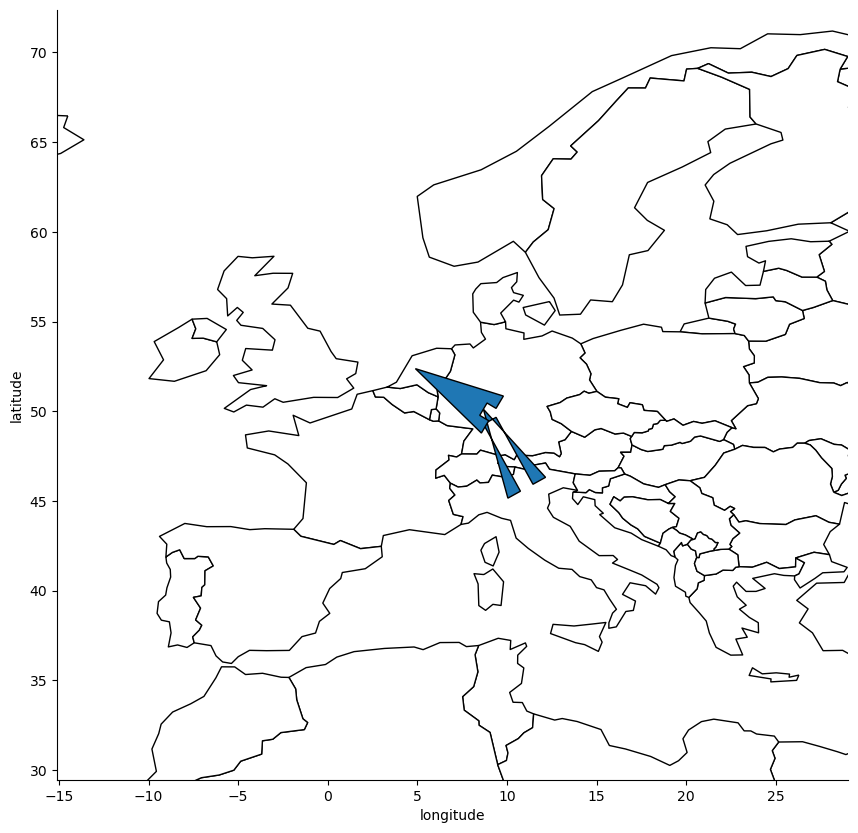

[{'rtts': [], 'avg_rtt': nan, 'ips': {}, 'distance_from_last_ip': 0.0, 'distance_calc': {'start': (49.4685, 9.0415), 'end': (49.4685, 9.0415)}}, {'rtts': [], 'avg_rtt': nan, 'ips': {}, 'distance_from_last_ip': 0.0, 'distance_calc': {'start': (49.4685, 9.0415), 'end': (49.4685, 9.0415)}}, {'rtts': [], 'avg_rtt': nan, 'ips': {}, 'distance_from_last_ip': 0.0, 'distance_calc': {'start': (49.4685, 9.0415), 'end': (49.4685, 9.0415)}}, {'rtts': [], 'avg_rtt': nan, 'ips': {}, 'distance_from_last_ip': 0.0, 'distance_calc': {'start': (49.4685, 9.0415), 'end': (49.4685, 9.0415)}}, {'rtts': [], 'avg_rtt': nan, 'ips': {}, 'distance_from_last_ip': 0.0, 'distance_calc': {'start': (49.4685, 9.0415), 'end': (49.4685, 9.0415)}}, {'rtts': [27.634], 'avg_rtt': 27.634, 'ips': {'193.0.14.129': {'ip': '193.0.14.129', 'hostname': 'k.root-servers.net', 'anycast': True, 'city': 'Amsterdam', 'region': 'North Holland', 'country': 'NL', 'loc': '52.3740,4.8897', 'org': 'AS25152 Reseaux IP Europeens Network Coordina

In [6]:
visualise_traceroute([detailed_routes[4]])

In [7]:
top_ips = dict(sorted(top_ips.items(), key=lambda item: item[1]))

countries_flag = []
countries_name = []
cities = []
freqs = []
data = []
for ip in top_ips:
    # This is likely already cached
    details = handler.getDetails(ip).all

    org = "Unknown"
    if details.get("org"):
        org = details.get("org").split(" ")[0]

    data.append([
        top_ips[ip],
        details.get("city"),
        details.get("country_flag").get("emoji"),
        details.get("country_name"),
        org,
        ip
    ])

hitlist = pd.DataFrame(data=data, columns=["Hits", "City", "Flag", "Country", "Organization", "IP Address"])[::-1].head(20).set_index("IP Address")
hitlist

,Hits,City,Flag,Country,Organization
IP Address,,,,,
193.239.116.217,13821,Amsterdam,🇳🇱,Netherlands,Unknown
80.81.192.154,9528,Frankfurt am Main,🇩🇪,Germany,Unknown
62.115.37.20,9050,Frankfurt am Main,🇩🇪,Germany,AS1299
72.52.92.70,8546,Frankfurt am Main,🇩🇪,Germany,AS6939
184.104.197.186,7301,Amsterdam,🇳🇱,Netherlands,AS6939
206.224.65.178,7270,Chicago,🇺🇸,United States,AS14593
206.224.65.184,7182,Chicago,🇺🇸,United States,AS14593
206.224.65.182,7178,Chicago,🇺🇸,United States,AS14593
206.224.65.180,7101,Chicago,🇺🇸,United States,AS14593


In [8]:
columns = ["Hits", "City", "Country", "Organization", "IP Address"]
print(hitlist.to_latex(index=False, bold_rows=True, label="fig:ip-hitlist-traceroute", caption="IP Hitlist for Built-In Traceroute Measurements", columns=columns))

\begin{table}
\caption{IP Hitlist for Built-In Traceroute Measurements}
\label{fig:ip-hitlist-traceroute}
\begin{tabular}{rlll}
\toprule
Hits & City & Country & Organization \\
\midrule
13821 & Amsterdam & Netherlands & Unknown \\
9528 & Frankfurt am Main & Germany & Unknown \\
9050 & Frankfurt am Main & Germany & AS1299 \\
8546 & Frankfurt am Main & Germany & AS6939 \\
7301 & Amsterdam & Netherlands & AS6939 \\
7270 & Chicago & United States & AS14593 \\
7182 & Chicago & United States & AS14593 \\
7178 & Chicago & United States & AS14593 \\
7101 & Chicago & United States & AS14593 \\
6104 & Tokyo & Japan & Unknown \\
5762 & Chicago & United States & AS14593 \\
5759 & Prague & Czech Republic & Unknown \\
5738 & Chicago & United States & AS14593 \\
5730 & Chicago & United States & AS14593 \\
5639 & Chicago & United States & AS14593 \\
5558 & Singapore & Singapore & AS2497 \\
5329 & Chicago & United States & AS14593 \\
5296 & Chicago & United States & AS14593 \\
5287 & Chicago & United S

# Latency per AS Hops

In [3]:
probesdf = pd.read_parquet('./parquet/ripe_atlas_probe_data.parquet')
probesdf

FileNotFoundError: [Errno 2] No such file or directory: './parquet/ripe_atlas_probe_data.parquet'